## **MIT IAP 2020: Structure and Interpretation of Deep Networks**

### Lecture 2: Explaining Predictions
#### _~ Methods for Understanding and Interpreting the Behaviour of Neural-NLP Models_

| Sebastian Gehrmann & Mirac Suzgun

In [0]:
## Importing relevant libraries and dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.autograd import Variable

from torchtext import data, datasets

import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from numpy import linalg as LA
# import seaborn as sns; sns.set()

# Matplotlib plt default settings
plt.style.use('default')

In [0]:
## GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

## Hyperparameters
BATCH_SIZE = 512

cuda


### 1) Set up the Data

A neural netork can only handle numerical inputs. Since text is represented as a sequences of words, we first need to map the words to integers. Luckily, we can use ***torchtext*** to process the text for us. 

In this lab, we will use the SST-2 corpus. The corpus comprises movie reviews with one sentence per review. The goal is to classify whether a review is positive or negative. 

In [0]:
## Download and processthe SST-2 corpus

# Set up input/output as torchtext Field objects
TEXT = data.Field(
    lower=True, # Lowercase all text
    batch_first=True) # order the tensor with batch as the first dimension  
LABEL = data.Field(
    sequential=False, # Do not tokenize the label (it is a single "pos"/"neg")
    unk_token=None) # Do not add an "unknown" token (not needed for label)

# Make splits for the dataset
# Filter out examples that are neutral
train_split, valid_split, test_split = datasets.SST.splits(
    TEXT, 
    LABEL, 
    filter_pred=lambda ex: ex.label != 'neutral')

# Build the vocabulary
# This builds an index such that "the" -> 1, "dog" -> 2 etc. 
TEXT.build_vocab(train_split,)
LABEL.build_vocab(train_split)

# Make iterator for splits
train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (train_split, valid_split, test_split), batch_size=BATCH_SIZE, device=device)

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:00<00:00, 1.62MB/s]


extracting


### 2) Check that the processing has worked

We have sucessfully built an ***Iterator*** for our data. This is an iterable that spits out one batch at a time of processed data. The text is converted to sequences of integers that represent the words and the labels are 0's and 1's. 

Among others, the iterator also handles the padding -- padding adds special symbols to shorter sequences such that all items in a batch have the same length. Without it, we could not fit a batch into a matrix with fixed width. 

To check that everything is functioning as expected, let's see how it works: 



In [0]:
print('Number of unique words in our input texts')
print('len(TEXT.vocab)', len(TEXT.vocab))
print('Number of labels in our corpus')
print('len(LABEL.vocab)', len(LABEL.vocab))

Number of unique words in our input texts
len(TEXT.vocab) 14830
Number of labels in our corpus
len(LABEL.vocab) 2


In [0]:
# Get the first batch of the dataset
batch = next(iter(train_iter))
print('Size of text batch: {} examples of length {}.'.format(
    *batch.text.shape))
# Grab the very first example within the batch
example_text = batch.text [0, :]
print()
print('The tokenized example has a length of {} and looks as follows'.format(
    len(example_text)))
print(example_text)
print('The label for the example is:', batch.label[0])

# We can easily convert it back to text like this: 
print()
print('Converted back to string:', ' '.join(
    [TEXT.vocab.itos[i] for i in example_text.tolist()]))

Size of text batch: 512 examples of length 52.

The tokenized example has a length of 52 and looks as follows
tensor([5503,   97,   13, 2106, 3162,    7, 1468,    4,  837,   88,  231, 3352,
        4677,   37,  114,   68,   88,  293,   32,    3,   48,    4,    6,  196,
          60, 7059,   55,   30,   77, 6574,   17,  139,  829, 2358,    2,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1], device='cuda:0')
The label for the example is: tensor(0, device='cuda:0')

Converted back to string: engages us in constant fits of laughter , until we find ourselves surprised at how much we care about the story , and end up walking out not only satisfied but also somewhat touched . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Let's build some helper functions to convert from string to id's and back

In [0]:
# Print the sentence given the indices
def ind2sent(vals):
    return (" ".join([TEXT.vocab.itos[i.item()] for i in vals]))

# Get the vectorized version of a sentence
def sent2ind(sentence):
    words = sentence.split (' ')
    arr = [TEXT.vocab.stoi[word] for word in words]
    return torch.tensor (arr).long()

In [0]:
# An example sentence 
ind2sent (example_text)

'engages us in constant fits of laughter , until we find ourselves surprised at how much we care about the story , and end up walking out not only satisfied but also somewhat touched . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

### Models

We are now building a model that we can use to train the sentiment classifier

In [0]:
# Save the index that represents the padding symbol
PAD_IX = TEXT.vocab.stoi['<pad>']

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200

# CNN setup
N_FILTERS = 25
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5

# LSTM setup
HIDDEN_DIM = 128
NUM_LAYERS = 2

In [0]:
class CNN (nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, n_filters, filter_sizes, dropout):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Conv2d(
                in_channels = 1, 
                out_channels = n_filters, 
                kernel_size = (fs, embedding_dim)) 
             for fs in filter_sizes])
        self.fc = nn.Linear(
            len(filter_sizes) * n_filters, 
            output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, embedded):
        # embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]    
        # conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        output = self.fc(cat).sigmoid ().squeeze()
        return output

In [0]:
# Eval
def eval (model, test_iter = test_iter):
    correct_preds = 0
    total_examples = 0
    
    # Turn on the test mode
    model.eval ()
    with torch.no_grad():
        for index, batch in enumerate(test_iter):
            # Input and target
            input = batch.text
            target = batch.label.long()
            # Feed the input to the model
            predictions = model (embedding(input))
            predictions = (predictions >= 0.5).long().squeeze()
            
            total_examples += len(target)
            correct_preds += (predictions == target).sum().item()

    return correct_preds/total_examples

In [0]:
# Training loop
def train(model, embedding, criterion, optim, n_epochs=5):
    # Turn on the train mode
    model.train()
    for epoch in range (n_epochs):
        # Set up progress bar
        tracker =  tqdm(enumerate(train_iter), 
                                 total=len(train_iter),
                                 desc='Epoch {}'.format(epoch+1))
        for index, batch in tracker:
            # Initialize the optimizer
            optim.zero_grad()
            
            # Input and target
            input = batch.text
            target = batch.label.float()
            
            # Feed the input to the model
            predictions = model(embedding(input))
            
            loss = criterion(predictions, target)
            
            # Perform updates in backpropogation
            loss.backward()
            optim.step()
            
            # Report the loss on progress bar every 10 batches
            if index % 10 == 0:
                tracker.set_postfix(loss=loss.item())

In [0]:
# Build the model
# Embedding module setup 
embedding = nn.Embedding(
    len(TEXT.vocab), 
    EMBEDDING_DIM, 
    padding_idx = PAD_IX).to(device)
# CNN model
model = CNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            OUTPUT_DIM, 
            N_FILTERS, 
            FILTER_SIZES, 
            DROPOUT).to(device)

# Binary cross entropy loss
loss = nn.BCELoss()
# Learning rate
learning_rate = 0.003
# Adam optimizer
optimizer = torch.optim.Adam(
    list(embedding.parameters()) + list(model.parameters()), 
    lr=learning_rate)

print (model)

CNN(
  (convs): ModuleList(
    (0): Conv2d(1, 25, kernel_size=(3, 200), stride=(1, 1))
    (1): Conv2d(1, 25, kernel_size=(4, 200), stride=(1, 1))
    (2): Conv2d(1, 25, kernel_size=(5, 200), stride=(1, 1))
  )
  (fc): Linear(in_features=75, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [0]:
# Let us the train the model
EPOCH_NUM = 10
train (model, embedding, loss, optimizer, EPOCH_NUM)

In [0]:
# Let us evaluate the performance of the model on the test set
eval(model, test_iter)

0.7699066447007139

### Compute the Saliency for Words

We now have a functioning classifier and can start computing the importance of words in a sentence for a positive or negative review. 

One key difference to models in computer vision is that we have the mapping word -> word_id -> embedding. The embeddings receive the gradient updates, but are very high-dimensional. Therefore, the standard first-derivative saliency will yield EMEDDING_SIZE different importance numbers. Let's try this!

### One note before we start: 

We may have noticed that we separated the embedding layer from the rest of the model. This is because we want to retain positional information for the saliency (i.e., where in a sentence each word is). If we did not do this, we could only access the gradient information of the whole embedding layer, but not of the embedding of each individual word. 


In [0]:
# Helper to get a test example
def get_example():
    index = 0
    batch = next(iter(train_iter))
    print("Size of text batch:", batch.text.shape)    
    example_text = batch.text[index, :].view(1, -1)
    # Truncate up to PADDING (but min 5 for CNN width)
    example_text = example_text[:,:max(5,
                                       (example_text[0] == PAD_IX).nonzero()[0])]

    print("Size of text:", example_text.shape)  
    example_label = batch.label[index].view(-1, 1)

    # Sentence
    print("Next example:", ind2sent(example_text[0]))
    return example_text, example_label

In [0]:
ex_in, ex_out = get_example()
# zero the gradient
model.zero_grad ()
# Set up the embeddings as a variable
# Note: 
emb = Variable(embedding(ex_in))
emb.requires_grad = True
pred = model(emb)
pred.backward()

Size of text batch: torch.Size([512, 52])
Size of text: torch.Size([1, 20])
Next example: if you 're a fan of the series you 'll love it and probably want to see it twice .


In [0]:
# Wrong: Here we access the gradient of the embedding module
print(embedding.weight.grad.shape)
# As you can see, all gradients are accumulated

torch.Size([14830, 200])


In [0]:
# Correct: Here we access the gradient of "emb", the embeddings of the sentence, instead
print(emb.grad.shape)

torch.Size([1, 20, 200])


#### Move from saliency per embedding dimension to saliency per word

There are multiple possible ways to aggregate the gradient information. The most common one is to use the $L_2$-Norm. 
See [here](https://www.aclweb.org/anthology/N16-1082/) for more information.

In [0]:
# First, let's remove the extra dimension
# Then, we move the tensor to CPU to use numpy functions
emb_data = emb.grad.clone().squeeze(0).cpu().numpy()
emb_data.shape

(20, 200)

In [0]:
# Now, we can compute the L2-Norm per token
LA.norm(emb_data, 2, 1) 

array([0.01217163, 0.01668554, 0.01622135, 0.01750974, 0.0230252 ,
       0.01513573, 0.01504544, 0.02213993, 0.02050084, 0.02443752,
       0.0349284 , 0.03897633, 0.03744453, 0.04331505, 0.05649308,
       0.05047959, 0.04628858, 0.03023121, 0.01929593, 0.00924481],
      dtype=float32)

Let's put this together now. 

In [0]:
def compute_l2_gradient_saliency(model, embedding, example_text):
    # Turn off dropout
    embedding.eval()
    model.eval()
    # zero the gradient
    model.zero_grad()
    # Set up the embeddings as a variable
    emb = Variable(embedding(ex_in))
    emb.requires_grad = True
    pred = model(emb)
    pred.backward()
    # Move and reshape the gradient
    emb_data = emb.grad.clone().squeeze(0).cpu().numpy()
    # Compute the norm
    l2_saliency = LA.norm(emb_data, 2, 1) 
    return l2_saliency

Now we can use this function to visualize the saliency! 

In [0]:
def visualize_saliency(text, saliency):
    overall_importance = np.expand_dims(saliency, axis=0)
    plt.figure(figsize=(12, 1))
    ax = sns.heatmap (overall_importance, 
                      xticklabels=ind2sent(text[0]).split(' '),
                      yticklabels=[], 
                      cmap='coolwarm')
    plt.show()

Size of text batch: torch.Size([512, 45])
Size of text: torch.Size([1, 9])
Next example: you can practically hear george orwell turning over .


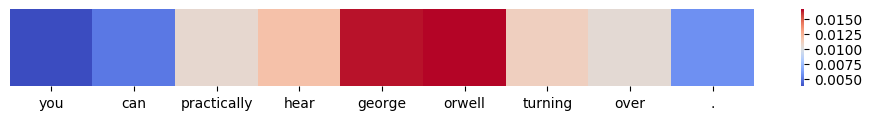

In [0]:
ex_in, ex_out = get_example()
saliency = compute_l2_gradient_saliency(model, embedding, ex_in)
visualize_saliency(ex_in, saliency)

## Task 1: Alternative Saliency

An alternative way to aggregate the importance measure is to take the embedding itself into account. 

Please see this paper for reference: https://arxiv.org/abs/1906.10282 (Eq.3 should have all information you need).

Fill in the following function:

In [0]:
def compute_input_gradient_saliency(model, embedding, example_text):
    # Fill in below
    # pass
    
    # Turn off dropout
    embedding.eval()
    model.eval()
    # zero the gradient
    model.zero_grad ()
    # Set up the embeddings as a variable
    emb = Variable(embedding(ex_in))
    emb.requires_grad = True
    pred = model(emb)
    pred.backward()
    # Move and reshape the gradient
    emb_data = (emb.grad * emb).squeeze(0).detach()
    emb_data = emb_data.cpu().numpy()
    # Compute the L-2 norm
    l2_saliency = LA.norm(emb_data, 2, 1) 
    return l2_saliency

Size of text batch: torch.Size([512, 51])
Size of text: torch.Size([1, 39])
Next example: it 's a hellish , numbing experience to watch , and it does n't offer any insights that have n't been thoroughly debated in the media already , back in the dahmer heyday of the mid - '90s .


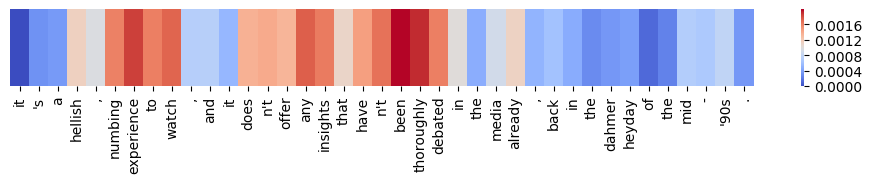

In [0]:
# Use this to test whether your function works
ex_in, ex_out = get_example()
saliency = compute_input_gradient_saliency(model, embedding, ex_in)
visualize_saliency(ex_in, saliency)


## Task 2: LSTM Saliency

Try switching the model to an LSTM-based one. Does the Saliency still work? 

In [0]:
class BiLSTMClassifier (nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 num_layers,
                 output_dim,
                 dropout):
        super().__init__()
        self.bilstm = nn.LSTM(input_size=embedding_dim, 
                              hidden_size=hidden_dim, 
                              num_layers=num_layers,
                              dropout=dropout,
                              bidirectional=True,
                              batch_first=True)
        self.fc = nn.Linear(
            2 * hidden_dim, 
            output_dim)
        self.dropout = nn.Dropout(dropout)
        # self.hidden = self.init_hidden()
    
    def init_hidden():
        return (torch.zeros(2, self.batch_size, self.hidden_dim).to(device),
                torch.zeros(2, self.batch_size, self.hidden_dim).to(device))
        
    def forward(self, embedded):
        # embedded = [batch size, sent len, emb dim]
        # lstm_out = [batch size, sent len, hid dim]
        lstm_out, _ = self.bilstm(embedded, None)
        lstm_out = self.dropout(lstm_out[:,-1,:])
        output = self.fc(lstm_out).sigmoid().squeeze(-1)
        return output

In [0]:
# LSTM module setup
lstm_model = BiLSTMClassifier(
    INPUT_DIM, 
    EMBEDDING_DIM, 
    HIDDEN_DIM,
    NUM_LAYERS,
    OUTPUT_DIM, 
    DROPOUT).to(device)

# Embedding module setup 
lstm_embedding = nn.Embedding(
    len(TEXT.vocab), 
    EMBEDDING_DIM, 
    padding_idx = PAD_IX).to(device)

learning_rate = 0.005
EPOCH_NUM = 20
optimizer = torch.optim.Adam(
    list(lstm_embedding.parameters()) + list(lstm_model.parameters()), 
    lr=learning_rate)

train(lstm_model, lstm_embedding, loss, optimizer, EPOCH_NUM)

In [0]:
eval(lstm_model, test_iter)

0.527732015376167

Now it's your turn:

In [0]:
# saliency

# Compare the Saliency scores between the LSTM and the CNN models

## Task 3: Extend the Saliency

Above, we had to create a separate module for embeddings to retrieve the gradients per word. However, there is a smarter way to do this. This way involves `hooks`. There are forward and backward hooks in PyTorch that get called during the forward/backward passes through a network. During the backward pass, we can access the gradient input and output of a module. 

Let's rewrite our code from above to compute saliency for the CNN model: 


In [0]:
print("example length:", ex_in.shape[1])
# Turn off dropout
embedding.eval()
model.eval()

# define hook
def backHook(module, gradInput, gradOutput):
    print("Gradient Input:", gradInput[0].shape)
    print("Gradient Output:", gradOutput[0].shape)
    print(gradOutput[0][0][0][:10])
    # Recompute the norm in here: 
    emb_data = gradOutput[0].clone().squeeze(0).cpu().numpy()
    l2_saliency = LA.norm(emb_data, 2, 1) 
    print(l2_saliency)

# Register the hook in the embedding
handle = embedding.register_backward_hook(backHook)
# zero the gradient
model.zero_grad()
# We no longer have to set up embedding as a Variable!
pred = model(embedding(ex_in))
print("PRED", pred.item(), "!!!!!!!")
print()
pred.backward()
# Remove the hook
handle.remove()

example length: 39
PRED 0.9969736337661743 !!!!!!!

Gradient Input: torch.Size([14830, 200])
Gradient Output: torch.Size([1, 39, 200])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
[0.         0.00036901 0.00049928 0.00118518 0.00114335 0.00172426
 0.00183625 0.00147571 0.00164107 0.0007507  0.00076688 0.00065869
 0.00131682 0.00127577 0.00148389 0.00170217 0.00149879 0.00115588
 0.00165017 0.00154931 0.00208401 0.00191958 0.00156226 0.00110973
 0.00050423 0.00099295 0.00098931 0.0005823  0.00061047 0.00053429
 0.00030985 0.00039686 0.000403   0.00014743 0.00025574 0.00082835
 0.0007052  0.00074061 0.00042659]


In [0]:
# Check that we get the same result the other way
saliency = compute_l2_gradient_saliency(model, embedding, ex_in)
saliency

array([0.        , 0.00036901, 0.00049928, 0.00118518, 0.00114335,
       0.00172426, 0.00183625, 0.00147571, 0.00164107, 0.0007507 ,
       0.00076688, 0.00065869, 0.00131682, 0.00127577, 0.00148389,
       0.00170217, 0.00149879, 0.00115588, 0.00165017, 0.00154931,
       0.00208401, 0.00191958, 0.00156226, 0.00110973, 0.00050423,
       0.00099295, 0.00098931, 0.0005823 , 0.00061047, 0.00053429,
       0.00030985, 0.00039686, 0.000403  , 0.00014743, 0.00025574,
       0.00082835, 0.0007052 , 0.00074061, 0.00042659], dtype=float32)

As you can see, hooks give us a much more powerful way to analyze the gradient information within a network. Let's try it!

The first classifier is a CNN-based model. That means that it can take multiple words into account at once. Extend the Saliency computation below to CNN filters and find out which ***phrases*** are the most relevant for an input, instead of individual words. 

Find the overall most salient phrases across the validation set. 